# Graphlet Correlation Analysis

Remember, in notebook *Thresholding*, I thresholded contact maps and saved so that
orca can read them.

In this notebook, I perform two actions:
1. I apply `count5` procedure in orca to extract 73 orbits for each loci in each
chromosome. After this stage, graphlets will be save with `.graphlets` extension 
in the `./data` folder.

2. I then read the graphlets and find both loci-wise distance
and graphlet-wise correlations
between the four cell lines.

By repeating steps 1 and 2 for all 23 chromosomes, I will have pairwise MIC values for all
orbits of all cell lines. I would eventually be able to have a data array of shape
``` A(23 * 73) ```, for each pair of cell lines where `A[i, j]` denotes the correlation
between the jth orbit in the ith chromosome. 


In [3]:
import numpy as np
import cv2
from utility import *
import matplotlib.pyplot as plt
from iced import normalization
from iced import filter
import os
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/watson/scripts/virt/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['colors', 'log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1. Orbit Extraction:
The following R-script reads edge files (`.edges`) corresponding to a chromosome under
 ```data/``` directory. It then writes the resulting orbits into
```data/*.graphlets```.

In [4]:
#for chr1 in range(1, 24):
#    os.system('Rscript rscript.r %s'%chr1)

# 2. Loci-wise Distance:
I can now read the orbitfiles and put them into a $N \times O$ matrix where $N$ denotes
number of loci in the chromosome and $O$ denotes the number or obitals extracted, which 
can be either 14 or 73 (depending on whether ```count4()``` or ```count5()``` are called
in the R-script above.

In [3]:
chr1 = 2
graphlets_mit = readMat("data/chr%02d_chr%02d_mit.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
graphlets_all = readMat("data/chr%02d_chr%02d_all.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
graphlets_rl = readMat("data/chr%02d_chr%02d_rl.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
graphlets_call4 = readMat("data/chr%02d_chr%02d_call4.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
print(graphlets_mit.shape)
print(graphlets_all.shape)
print(graphlets_rl.shape)
print(graphlets_call4.shape)

file directory: data/chr02_chr02_mit.graphlets
file directory: data/chr02_chr02_all.graphlets
file directory: data/chr02_chr02_rl.graphlets
file directory: data/chr02_chr02_call4.graphlets
(478, 73)
(478, 73)
(478, 73)
(478, 73)


### Calculating Loci-wise correlations:

In [4]:
mit_all_corr = \
    full_graphlet_distance(graphlets_mit, graphlets_all)

In [5]:
mit_mit_corr = \
    full_graphlet_distance(graphlets_mit, graphlets_mit)

In [6]:
mit_call4_corr = \
    full_graphlet_distance(graphlets_mit, graphlets_all)

In [7]:
mit_rl_corr = \
    full_graphlet_distance(graphlets_mit, graphlets_rl)


Number of columnts: 2


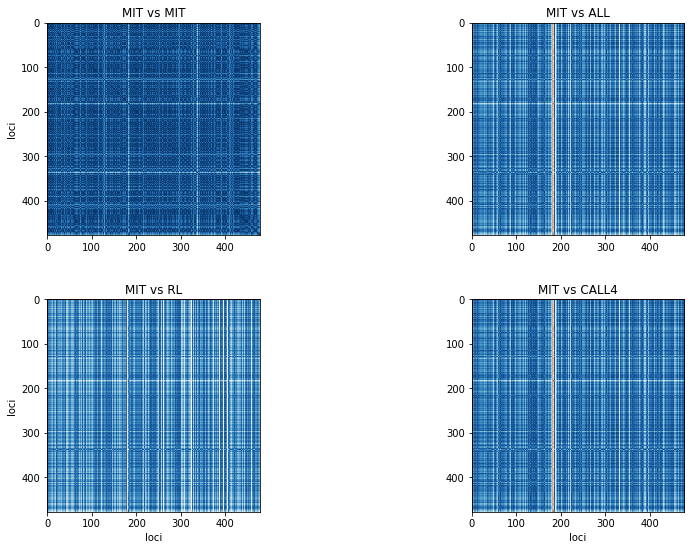

In [17]:
pylab.rcParams['figure.figsize'] = (15, 9)
images = [ mit_mit_corr
          , mit_all_corr
         , mit_rl_corr
         , mit_call4_corr]
ax_labels = (['loci', '', 'loci', ''] * 4, ['', '', 'loci', 'loci'] * 4)
titles = [ 'MIT vs MIT', 'MIT vs ALL', 'MIT vs RL', 'MIT vs CALL4']
showImages(images, 2, titles=titles, ax_labels=ax_labels)

In [265]:
print("Total correlation statistics")
print_statistics(mit_mit_corr, "mit vs mit")
print_statistics(mit_all_corr, "mit vs all")
print_statistics(mit_rl_corr, "mit vs rl")
print_statistics(mit_call4_corr, "mit vs call4")

print("\n\nCorrelation statistics between same loci")
print_statistics(np.diagonal(mit_mit_corr), "mit vs mit")
print_statistics(np.diagonal(mit_all_corr), "mit vs all")
print_statistics(np.diagonal(mit_rl_corr), "mit vs rl")
print_statistics(np.diagonal(mit_call4_corr), "mit vs call4")

print("\n\nCorrelation statistics between same loci")
print_statistics(row_wise_graphlet_distance(graphlets_mit, graphlets_mit),  "mit vs mit")
print_statistics(row_wise_graphlet_distance(graphlets_mit, graphlets_all),  "mit vs all")
print_statistics(row_wise_graphlet_distance(graphlets_mit, graphlets_rl),  "mit vs rl")
print_statistics(row_wise_graphlet_distance(graphlets_mit, graphlets_call4),  "mit vs call4")

Total correlation statistics
#-----------------------------------------------------------------------#
Stats for mit vs mit: 
max: 4.468946 | min: 0.000000 | median: 0.222504 | mean: 0.307916 | std: 0.507423
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs all: 
max: 4.468946 | min: 0.000000 | median: 0.291794 | mean: 0.391126 | std: 0.515128
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs rl: 
max: 4.469659 | min: 0.000000 | median: 0.852747 | mean: 0.899452 | std: 0.444342
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs call4: 
max: 4.468946 | min: 0.000000 | median: 0.291794 | mean: 0.391126 | std: 0.515128
#-------------------------------

(1.4147252181148513, 0.0, 0.6756736668622587, 0.18185658391449888)

In [5]:
cells = ['mit', 'all', 'rl', 'call4']
graphlets = [ None ] * 24
for chr1 in range(1, 24):
    graphlets[chr1] = {}
    for cell in cells:
       graphlets[chr1][cell] = readMat\
    ("data/chr%02d_chr%02d_%s.graphlets"%(chr1, chr1, cell), delimiter=" ").astype('uint32') 
    
distances = {}
for cell1 in cells:
    distances[cell1] = {}
    for cell2 in cells:
        if cell1 == cell2:
            continue
        distances[cell1][cell2] = np.zeros((24, 2))
        #cell (i, j) will store correlation between orbital j in 
        #ith chromosome
        
for cell1 in distances:
    for cell2 in distances[cell1]:
        for chr1 in range(1, 24):
            temp =  row_wise_graphlet_distance(graphlets[chr1][cell1]\
                            , graphlets[chr1][cell2])
            distances[cell1][cell2][chr1, 0] = np.nanmean(temp)
            distances[cell1][cell2][chr1, 1] = np.nanstd(temp)
print(distances)

file directory: data/chr01_chr01_mit.graphlets
file directory: data/chr01_chr01_all.graphlets
file directory: data/chr01_chr01_rl.graphlets
file directory: data/chr01_chr01_call4.graphlets
file directory: data/chr02_chr02_mit.graphlets
file directory: data/chr02_chr02_all.graphlets
file directory: data/chr02_chr02_rl.graphlets
file directory: data/chr02_chr02_call4.graphlets
file directory: data/chr03_chr03_mit.graphlets
file directory: data/chr03_chr03_all.graphlets
file directory: data/chr03_chr03_rl.graphlets
file directory: data/chr03_chr03_call4.graphlets
file directory: data/chr04_chr04_mit.graphlets
file directory: data/chr04_chr04_all.graphlets
file directory: data/chr04_chr04_rl.graphlets
file directory: data/chr04_chr04_call4.graphlets
file directory: data/chr05_chr05_mit.graphlets
file directory: data/chr05_chr05_all.graphlets
file directory: data/chr05_chr05_rl.graphlets
file directory: data/chr05_chr05_call4.graphlets
file directory: data/chr06_chr06_mit.graphlets
file dir

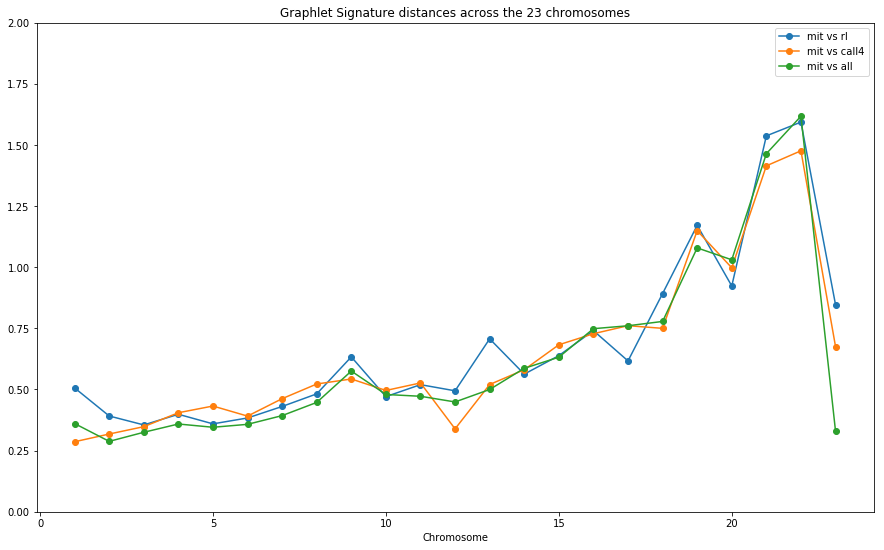

In [285]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(1, 24)
ax = plt.subplot(1, 1, 1)
ax.set_title("Graphlet Signature distances across the 23 chromosomes")
ax.set(xlabel="Chromosome")
for cell in distances['mit']:
    y = distances['mit'][cell][1:, 0]
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.set_ylim([0, 2])

plt.legend()
plt.show()

In [290]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(1, 24)
count = 1
plt.set_title('mardas')
for cell in distances['mit']:
    ax = plt.subplot(3, 1, count)
    count +=1
    y = distances['mit'][cell][1:, 0]
    y_error = distances['mit'][cell][1:,1]
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_ylim([0, 2.5])
    ax.legend()
ax.set(xlabel="Chromosome")
plt.show()

AttributeError: 'module' object has no attribute 'set_title'

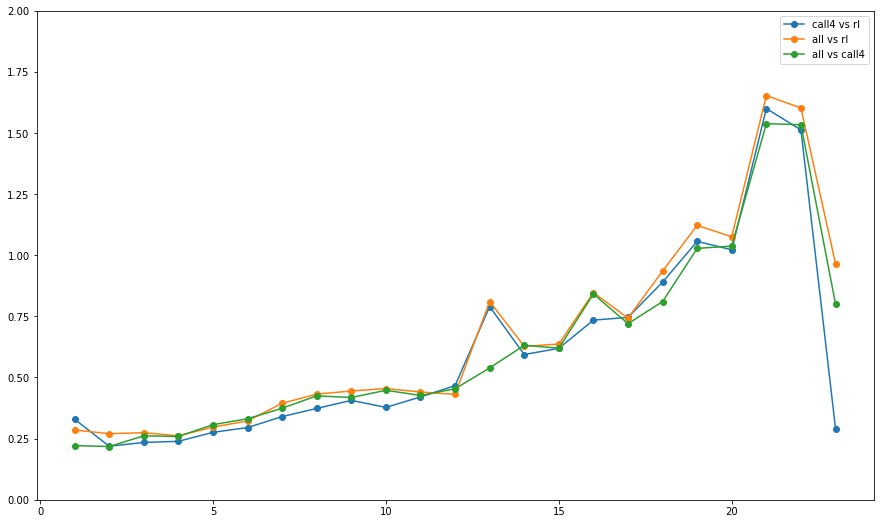

In [277]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(1, 24)
ax = plt.subplot(1, 1, 1)
for cell1 in distances:
    if cell1 == 'mit':
        continue
    for cell2 in distances[cell1]:
        if cell2 == 'mit' or cell1 >= cell2:
            continue
        y = distances[cell1][cell2][1:, 0]
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 2])

plt.legend()
plt.show()

In [182]:
n = mit_mit_corr.shape[0]
#t1 = (t_test(np.diagonal(mit_mit_corr)))
t2 = (t_test(np.diagonal(mit_all_corr)))
t3 = (t_test(np.diagonal(mit_rl_corr)))
t4 = (t_test(np.diagonal(mit_call4_corr)))
print(n)
#print(t1)
print("t statistic for mit vs all: %d"% t2)
print("t statistic for mit vs rl: %d"% t3)
print("t statistic for mit vs call4: %d"% t4)
from scipy.stats import t
print("p-value for mit-all: %10.3e"%(1 - t.cdf(t2, n-1)))
print("p-value for mit-rl: %10.3e"%(1 - t.cdf(t3, n-1)))
print("p-value for mit-call4: %10.3e"%(1 - t.cdf(t4, n-1)))

478
t statistic for mit vs all: 18
t statistic for mit vs rl: 19
t statistic for mit vs call4: 19
p-value for mit-all:  0.000e+00
p-value for mit-rl:  0.000e+00
p-value for mit-call4:  0.000e+00


# 3. Orbit-wise Correlation

file directory: data/chr01_chr01_mit.graphlets
file directory: data/chr01_chr01_all.graphlets
file directory: data/chr01_chr01_rl.graphlets
file directory: data/chr01_chr01_call4.graphlets
Number of columnts: 4


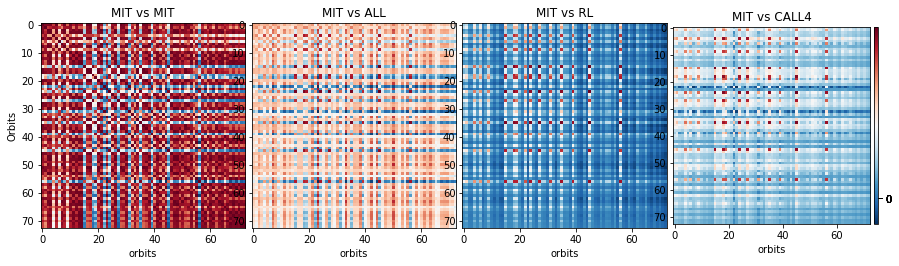

file directory: data/chr02_chr02_mit.graphlets
file directory: data/chr02_chr02_all.graphlets
file directory: data/chr02_chr02_rl.graphlets
file directory: data/chr02_chr02_call4.graphlets
Number of columnts: 4


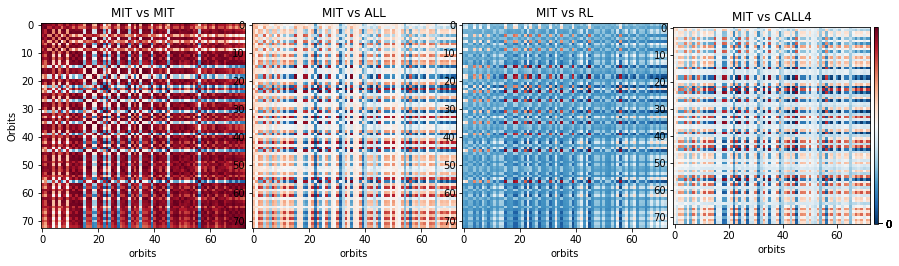

file directory: data/chr03_chr03_mit.graphlets
file directory: data/chr03_chr03_all.graphlets
file directory: data/chr03_chr03_rl.graphlets
file directory: data/chr03_chr03_call4.graphlets
Number of columnts: 4


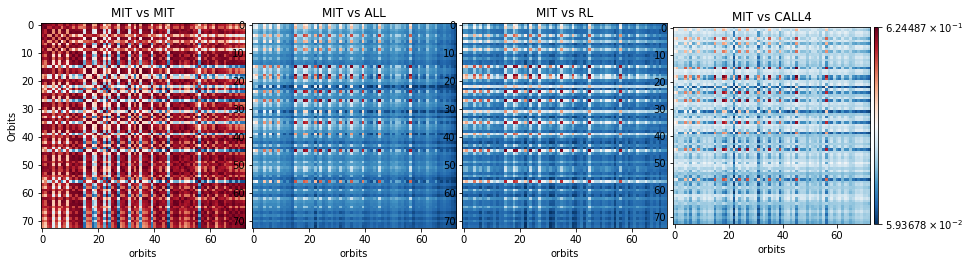

file directory: data/chr04_chr04_mit.graphlets
file directory: data/chr04_chr04_all.graphlets
file directory: data/chr04_chr04_rl.graphlets
file directory: data/chr04_chr04_call4.graphlets
Number of columnts: 4


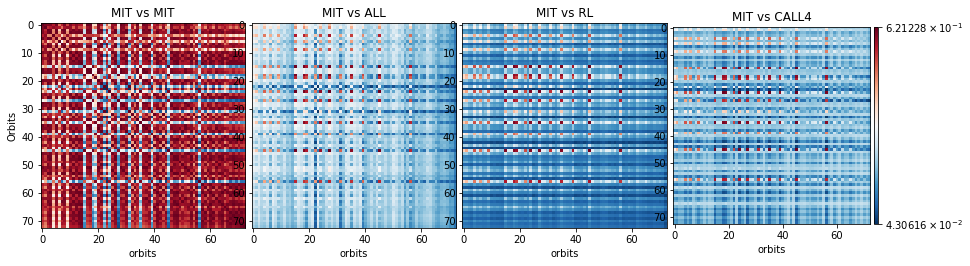

file directory: data/chr05_chr05_mit.graphlets
file directory: data/chr05_chr05_all.graphlets
file directory: data/chr05_chr05_rl.graphlets
file directory: data/chr05_chr05_call4.graphlets
Number of columnts: 4


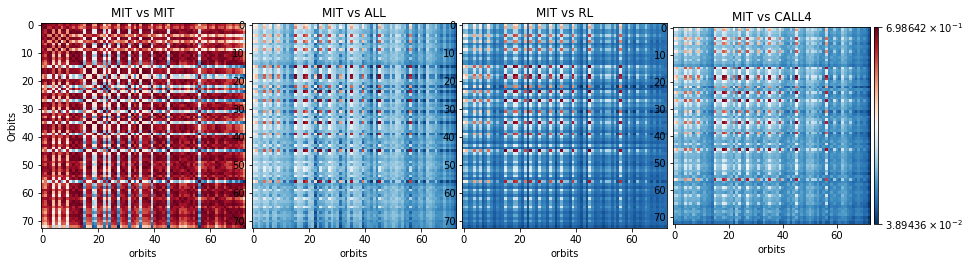

file directory: data/chr06_chr06_mit.graphlets
file directory: data/chr06_chr06_all.graphlets
file directory: data/chr06_chr06_rl.graphlets
file directory: data/chr06_chr06_call4.graphlets
Number of columnts: 4


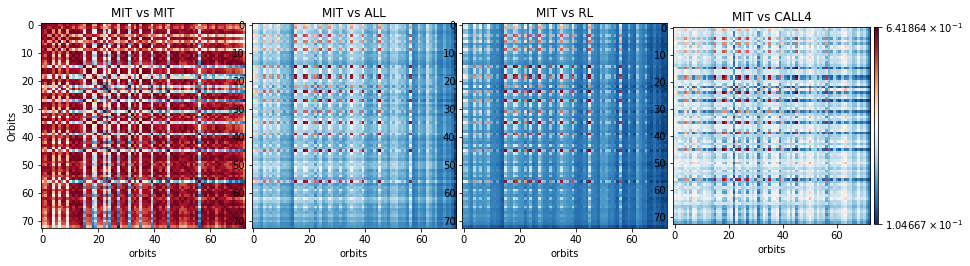

file directory: data/chr07_chr07_mit.graphlets
file directory: data/chr07_chr07_all.graphlets
file directory: data/chr07_chr07_rl.graphlets
file directory: data/chr07_chr07_call4.graphlets
Number of columnts: 4


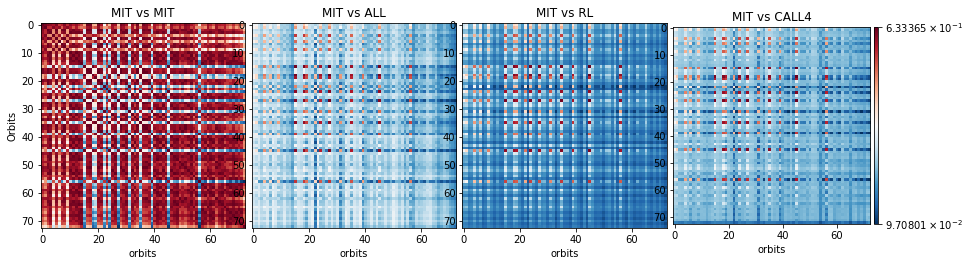

file directory: data/chr08_chr08_mit.graphlets
file directory: data/chr08_chr08_all.graphlets
file directory: data/chr08_chr08_rl.graphlets
file directory: data/chr08_chr08_call4.graphlets
Number of columnts: 4


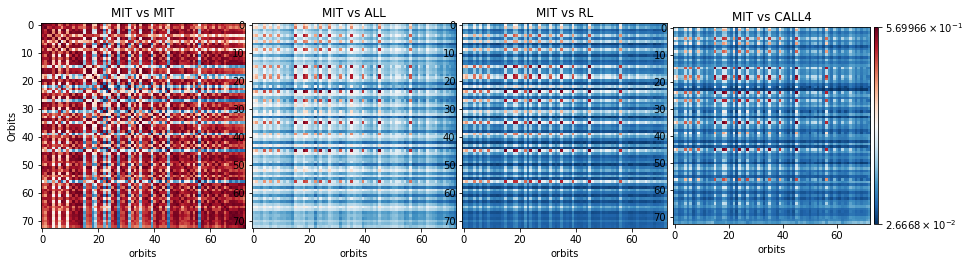

file directory: data/chr09_chr09_mit.graphlets
file directory: data/chr09_chr09_all.graphlets
file directory: data/chr09_chr09_rl.graphlets
file directory: data/chr09_chr09_call4.graphlets
Number of columnts: 4


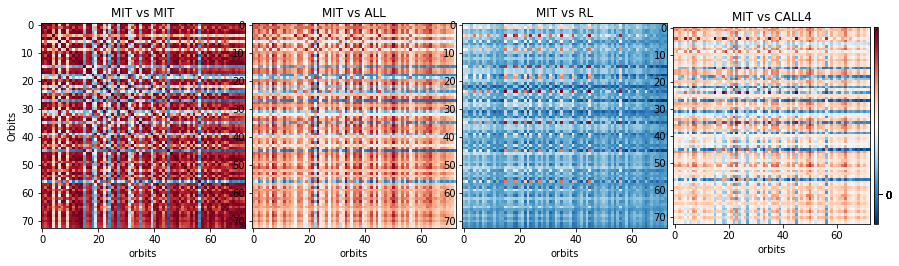

file directory: data/chr10_chr10_mit.graphlets
file directory: data/chr10_chr10_all.graphlets
file directory: data/chr10_chr10_rl.graphlets
file directory: data/chr10_chr10_call4.graphlets
Number of columnts: 4


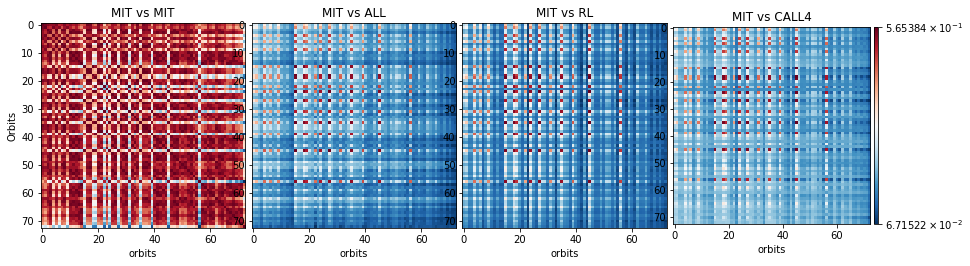

file directory: data/chr11_chr11_mit.graphlets
file directory: data/chr11_chr11_all.graphlets
file directory: data/chr11_chr11_rl.graphlets
file directory: data/chr11_chr11_call4.graphlets
Number of columnts: 4


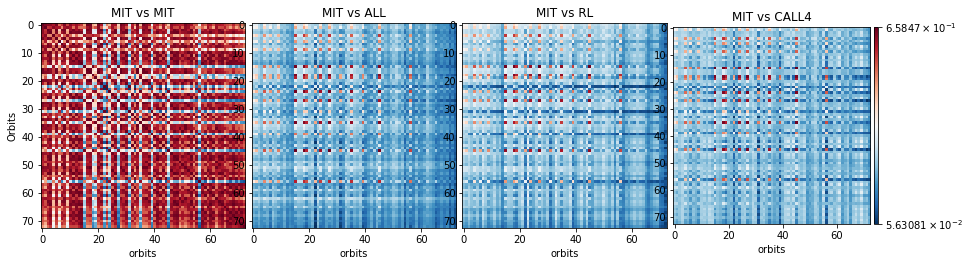

file directory: data/chr12_chr12_mit.graphlets
file directory: data/chr12_chr12_all.graphlets
file directory: data/chr12_chr12_rl.graphlets
file directory: data/chr12_chr12_call4.graphlets
Number of columnts: 4


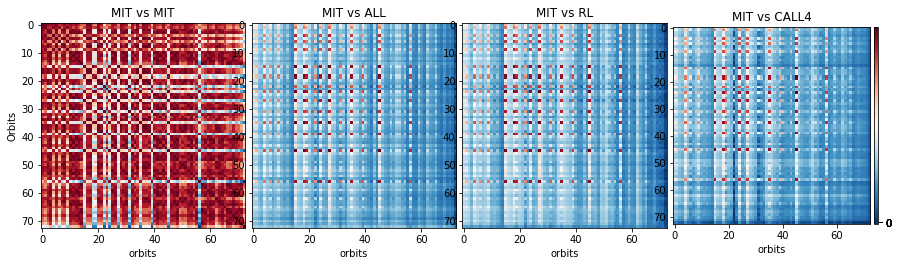

file directory: data/chr13_chr13_mit.graphlets
file directory: data/chr13_chr13_all.graphlets
file directory: data/chr13_chr13_rl.graphlets
file directory: data/chr13_chr13_call4.graphlets
Number of columnts: 4


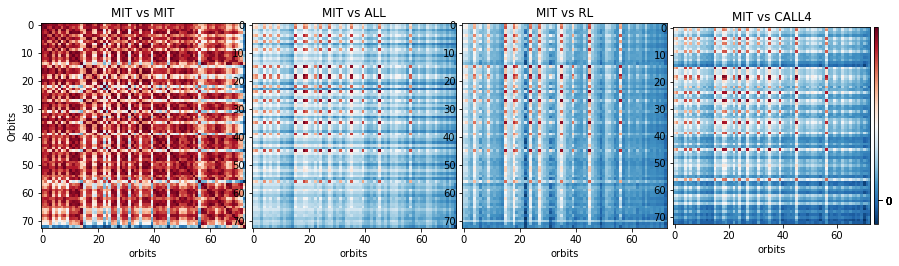

file directory: data/chr14_chr14_mit.graphlets
file directory: data/chr14_chr14_all.graphlets
file directory: data/chr14_chr14_rl.graphlets
file directory: data/chr14_chr14_call4.graphlets
Number of columnts: 4


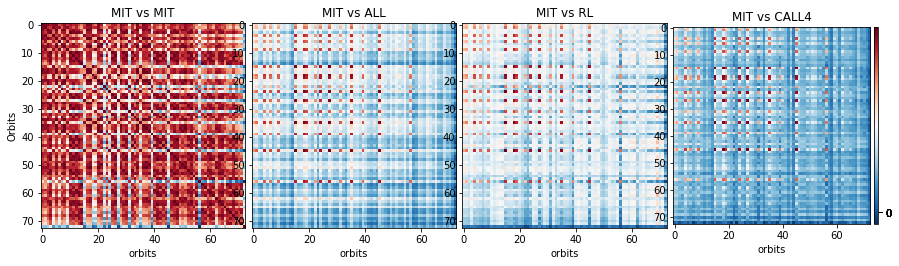

file directory: data/chr15_chr15_mit.graphlets
file directory: data/chr15_chr15_all.graphlets
file directory: data/chr15_chr15_rl.graphlets
file directory: data/chr15_chr15_call4.graphlets
Number of columnts: 4


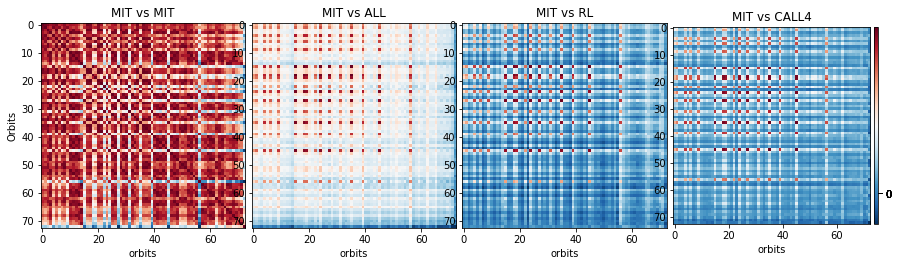

file directory: data/chr16_chr16_mit.graphlets
file directory: data/chr16_chr16_all.graphlets
file directory: data/chr16_chr16_rl.graphlets
file directory: data/chr16_chr16_call4.graphlets
Number of columnts: 4


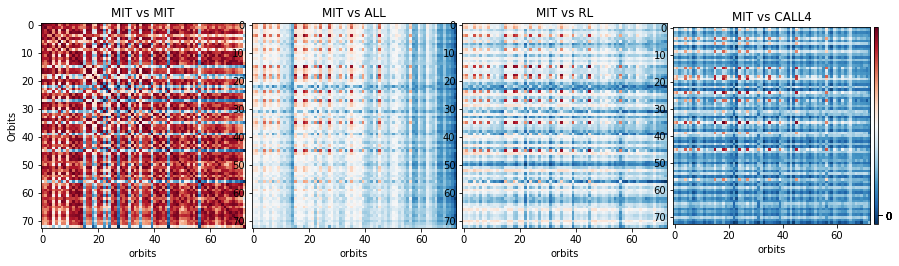

file directory: data/chr17_chr17_mit.graphlets
file directory: data/chr17_chr17_all.graphlets
file directory: data/chr17_chr17_rl.graphlets
file directory: data/chr17_chr17_call4.graphlets
Number of columnts: 4


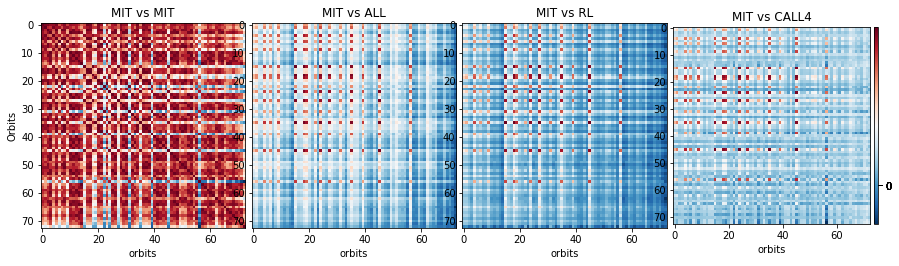

file directory: data/chr18_chr18_mit.graphlets
file directory: data/chr18_chr18_all.graphlets
file directory: data/chr18_chr18_rl.graphlets
file directory: data/chr18_chr18_call4.graphlets
Number of columnts: 4


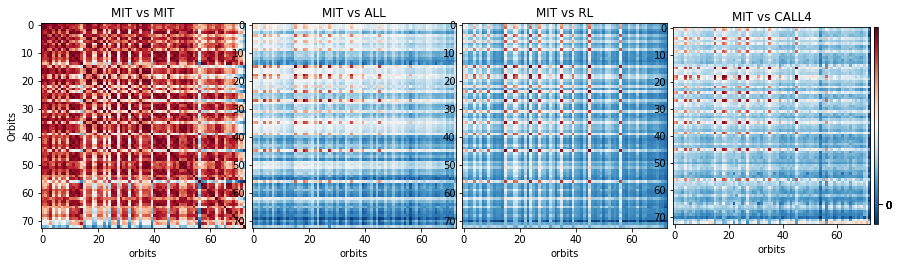

file directory: data/chr19_chr19_mit.graphlets
file directory: data/chr19_chr19_all.graphlets
file directory: data/chr19_chr19_rl.graphlets
file directory: data/chr19_chr19_call4.graphlets
Number of columnts: 4


/home/bzr0014/watson/scripts/virt/local/lib/python2.7/site-packages/matplotlib/colors.py:1114: RuntimeWarning: invalid value encountered in greater
  masked = np.abs(a) > self.linthresh


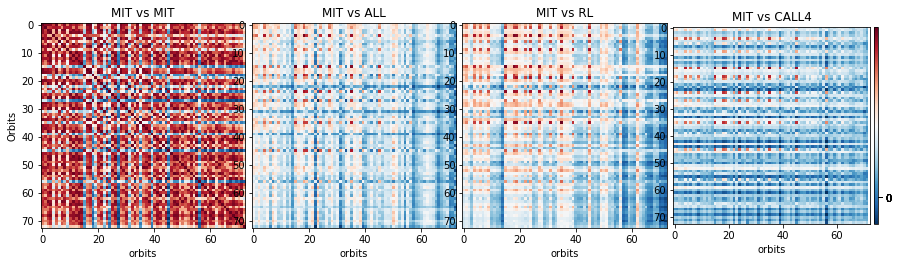

file directory: data/chr20_chr20_mit.graphlets
file directory: data/chr20_chr20_all.graphlets
file directory: data/chr20_chr20_rl.graphlets
file directory: data/chr20_chr20_call4.graphlets
Number of columnts: 4


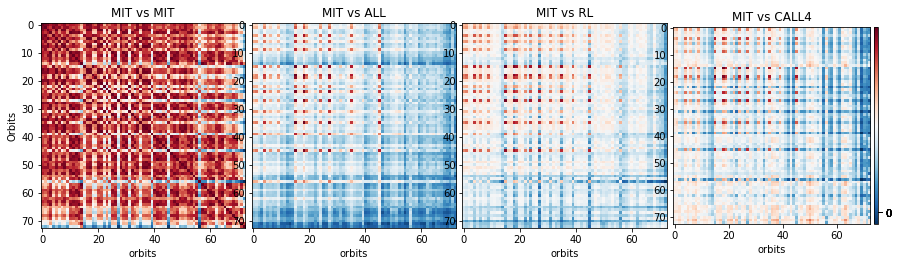

file directory: data/chr21_chr21_mit.graphlets
file directory: data/chr21_chr21_all.graphlets
file directory: data/chr21_chr21_rl.graphlets
file directory: data/chr21_chr21_call4.graphlets
Number of columnts: 4


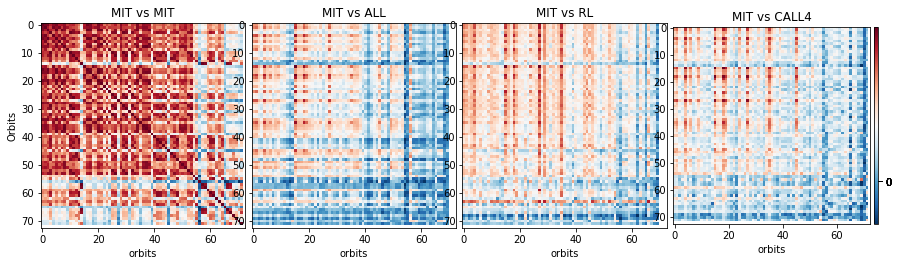

file directory: data/chr22_chr22_mit.graphlets
file directory: data/chr22_chr22_all.graphlets
file directory: data/chr22_chr22_rl.graphlets
file directory: data/chr22_chr22_call4.graphlets
Number of columns (68 and 67) not the same.
            picking the minimum value...
Number of columnts: 4


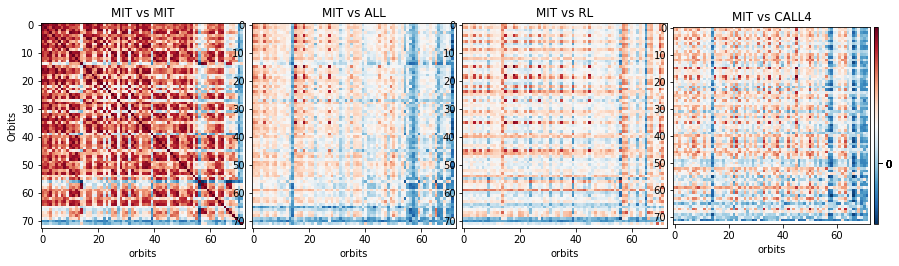

file directory: data/chr23_chr23_mit.graphlets
file directory: data/chr23_chr23_all.graphlets
file directory: data/chr23_chr23_rl.graphlets
file directory: data/chr23_chr23_call4.graphlets
Number of columnts: 4


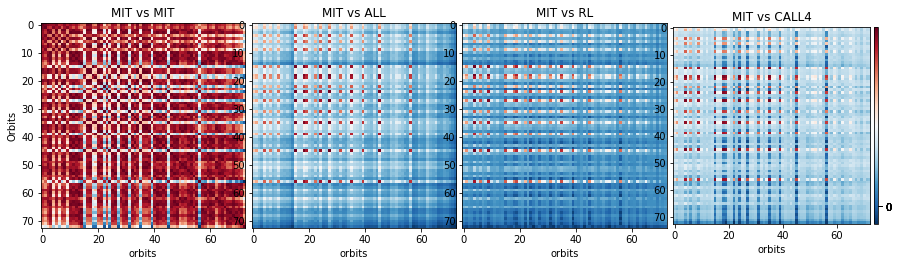

In [13]:
pylab.rcParams['figure.figsize'] = (15, 9)
for chr1 in range(1, 24):
    graphlets_mit = readMat\
    ("data/chr%02d_chr%02d_mit.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
    graphlets_all = readMat\
    ("data/chr%02d_chr%02d_all.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
    graphlets_rl = readMat\
    ("data/chr%02d_chr%02d_rl.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
    graphlets_call4 = readMat\
    ("data/chr%02d_chr%02d_call4.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
    mit_all_corr_orbit_wise = \
        pearson(graphlets_mit.T, graphlets_all.T)
    mit_mit_corr_orbit_wise= \
        pearson(graphlets_mit.T, graphlets_mit.T)
    mit_call4_corr_orbit_wise= \
        pearson(graphlets_mit.T, graphlets_call4.T)
    mit_rl_corr_orbit_wise= \
        pearson(graphlets_mit.T, graphlets_rl.T)
    images = [ mit_mit_corr_orbit_wise
          , mit_all_corr_orbit_wise
         , mit_rl_corr_orbit_wise
         , mit_call4_corr_orbit_wise
         ]
    ax_labels =( ['Orbits', '', '', ''], ['orbits'] * 4)
    titles = ['MIT vs MIT', 'MIT vs ALL', 'MIT vs RL', 'MIT vs CALL4']
    showImages(images, 1, ax_labels=ax_labels, titles=titles, color_bar=True)

In [198]:
for chr1 in range(1, 24):
    print("Chromosome %d"%(chr1))
    graphlets_mit = readMat\
    ("data/chr%02d_chr%02d_mit.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
    graphlets_all = readMat\
    ("data/chr%02d_chr%02d_all.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
    graphlets_rl = readMat\
    ("data/chr%02d_chr%02d_rl.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
    graphlets_call4 = readMat\
    ("data/chr%02d_chr%02d_call4.graphlets"%(chr1, chr1), delimiter=" ").astype('uint32')
    mit_all_corr_orbit_wise = \
        pearson(graphlets_mit.T, graphlets_all.T)
    mit_mit_corr_orbit_wise= \
        pearson(graphlets_mit.T, graphlets_mit.T)
    mit_call4_corr_orbit_wise= \
        pearson(graphlets_mit.T, graphlets_call4.T)
    mit_rl_corr_orbit_wise= \
        pearson(graphlets_mit.T, graphlets_rl.T) 
    print_statistics(np.diagonal(mit_mit_corr_orbit_wise), 'mit vs mit')
    print_statistics(np.diagonal(mit_all_corr_orbit_wise), 'mit vs all')
    print_statistics(np.diagonal(mit_rl_corr_orbit_wise), 'mit vs rl')
    print_statistics(np.diagonal(mit_call4_corr_orbit_wise), 'mit vs call4')

Chromosome 1
file directory: data/chr01_chr01_mit.graphlets
file directory: data/chr01_chr01_all.graphlets
file directory: data/chr01_chr01_rl.graphlets
file directory: data/chr01_chr01_call4.graphlets
#-----------------------------------------------------------------------#
Stats for mit vs mit: 
max: 1.000000 | min: 1.000000 | median: 1.000000 | mean: 1.000000 | std: 0.000000
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs all: 
max: 0.691546 | min: 0.264693 | median: 0.447225 | mean: 0.458319 | std: 0.107821
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs rl: 
max: 0.488262 | min: 0.005228 | median: 0.064152 | mean: 0.115254 | std: 0.145756
#-----------------------------------------------------------------------#
#---------------------------------------

#-----------------------------------------------------------------------#
Stats for mit vs mit: 
max: 1.000000 | min: 1.000000 | median: 1.000000 | mean: 1.000000 | std: 0.000000
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs all: 
max: 0.622792 | min: 0.064770 | median: 0.218786 | mean: 0.241913 | std: 0.149463
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs rl: 
max: 0.548060 | min: -0.072579 | median: 0.022616 | mean: 0.081929 | std: 0.183618
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs call4: 
max: 0.565263 | min: 0.029225 | median: 0.136874 | mean: 0.176655 | std: 0.141294
#-----------------------------------------------------------

#-----------------------------------------------------------------------#
Stats for mit vs mit: 
max: 1.000000 | min: 1.000000 | median: 1.000000 | mean: 1.000000 | std: 0.000000
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs all: 
max: 0.627744 | min: -0.082786 | median: 0.270007 | mean: 0.295242 | std: 0.137112
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs rl: 
max: 0.563995 | min: -0.032939 | median: 0.066092 | mean: 0.130166 | std: 0.169149
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs call4: 
max: 0.555546 | min: -0.105676 | median: 0.049453 | mean: 0.122544 | std: 0.172953
#---------------------------------------------------------

Number of columns (68 and 67) not the same.
            picking the minimum value...
#-----------------------------------------------------------------------#
Stats for mit vs mit: 
max: nan | min: nan | median: nan | mean: nan | std: nan
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs all: 
max: nan | min: nan | median: nan | mean: nan | std: nan
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs rl: 
max: nan | min: nan | median: nan | mean: nan | std: nan
#-----------------------------------------------------------------------#
#-----------------------------------------------------------------------#
Stats for mit vs call4: 
max: nan | min: nan | median: nan | mean: nan | std: nan
#-----------------------------------------------------------------------#
Ch

Now Let's repeat the above procedure for all 23 chromosomes and store them in a dictionary:

In [7]:
cells = ['mit', 'all', 'rl', 'call4']
graphlets = [ None ] * 24
for chr1 in range(1, 24):
    graphlets[chr1] = {}
    for cell in cells:
       graphlets[chr1][cell] = readMat\
    ("data/chr%02d_chr%02d_%s.graphlets"%(chr1, chr1, cell), delimiter=" ").astype('uint32') 
    
correlations = {}
for cell1 in cells:
    correlations[cell1] = {}
    for cell2 in cells:
        if cell1 == cell2:
            continue
        correlations[cell1][cell2] = np.zeros((24, 73))
        #cell (i, j) will store correlation between orbital j in 
        #ith chromosome
        
for chr1 in range(1, 24):
    for cell1 in correlations:
        for cell2 in correlations[cell1]:
            correlations[cell1][cell2][chr1, :] = \
                row_wise_pearson(graphlets[chr1][cell1].T, graphlets[chr1][cell2].T)

file directory: data/chr01_chr01_mit.graphlets
file directory: data/chr01_chr01_all.graphlets
file directory: data/chr01_chr01_rl.graphlets
file directory: data/chr01_chr01_call4.graphlets
file directory: data/chr02_chr02_mit.graphlets
file directory: data/chr02_chr02_all.graphlets
file directory: data/chr02_chr02_rl.graphlets
file directory: data/chr02_chr02_call4.graphlets
file directory: data/chr03_chr03_mit.graphlets
file directory: data/chr03_chr03_all.graphlets
file directory: data/chr03_chr03_rl.graphlets
file directory: data/chr03_chr03_call4.graphlets
file directory: data/chr04_chr04_mit.graphlets
file directory: data/chr04_chr04_all.graphlets
file directory: data/chr04_chr04_rl.graphlets
file directory: data/chr04_chr04_call4.graphlets
file directory: data/chr05_chr05_mit.graphlets
file directory: data/chr05_chr05_all.graphlets
file directory: data/chr05_chr05_rl.graphlets
file directory: data/chr05_chr05_call4.graphlets
file directory: data/chr06_chr06_mit.graphlets
file dir

/home/bzr0014/watson/scripts/virt/local/lib/python2.7/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


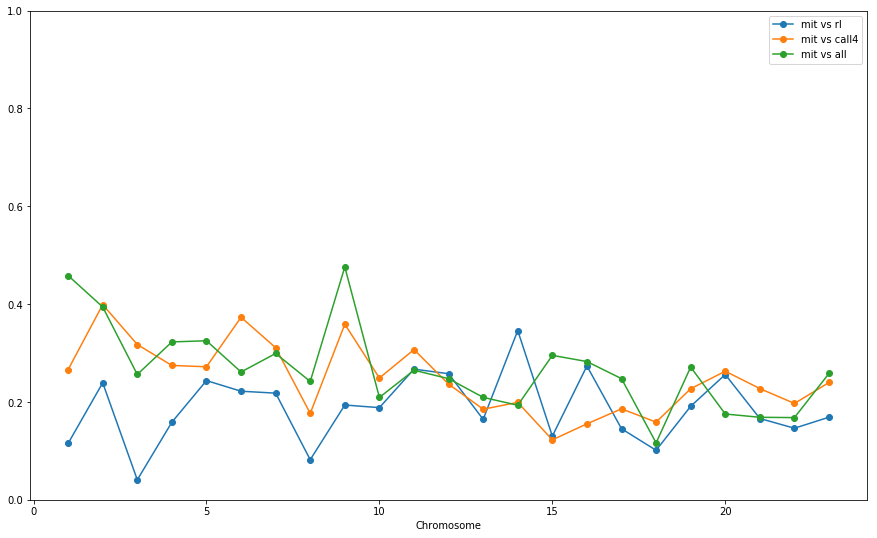

In [8]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(1, 24)
ax = plt.subplot(1, 1, 1)
for cell in correlations['mit']:
    y = np.nanmean(correlations['mit'][cell][1:,:], axis=1)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.set(ylim=[0, 1], xlabel='Chromosome')
plt.legend()
plt.show()

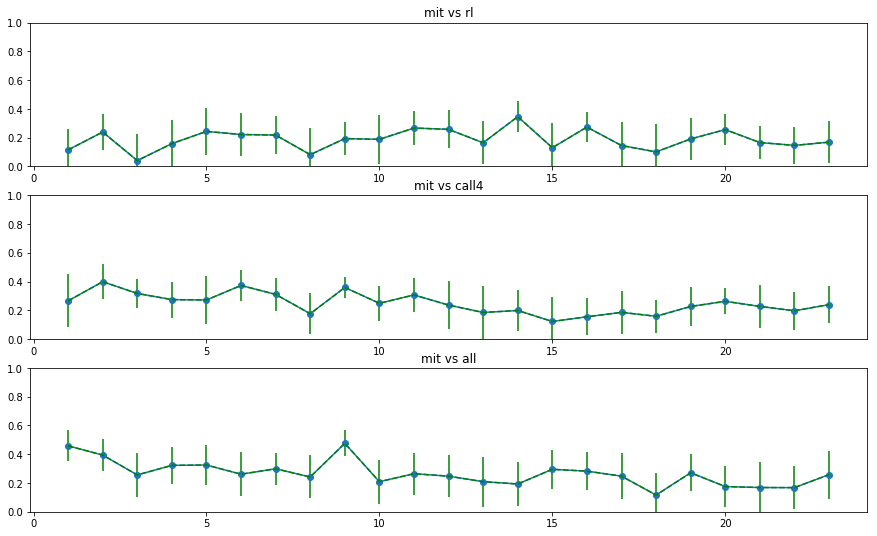

In [32]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(1, 24)
count = 1
for cell in correlations['mit']:
    ax = plt.subplot(3, 1, count)
    count += 1
    temp = correlations['mit'][cell][1:,:]
    y = np.nanmean(temp, axis=1)
    y_error = np.nanstd(temp, axis=1)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_title("mit vs %s"%cell)
    ax.set_ylim([0, 1])
plt.show()

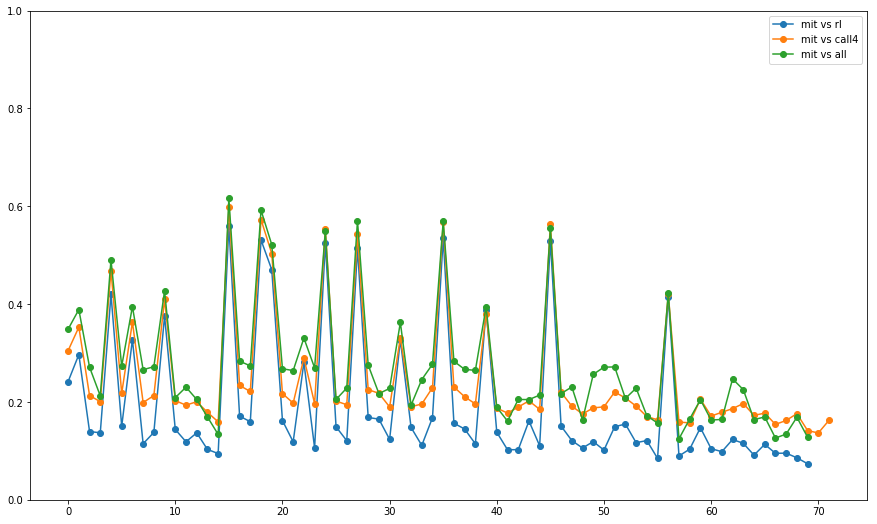

In [33]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(73)
ax = plt.subplot(1, 1, 1)
for cell in correlations['mit']:
    y = np.mean(correlations['mit'][cell][1:,:], axis=0)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.set_ylim([0, 1])
    
plt.legend()
plt.show()

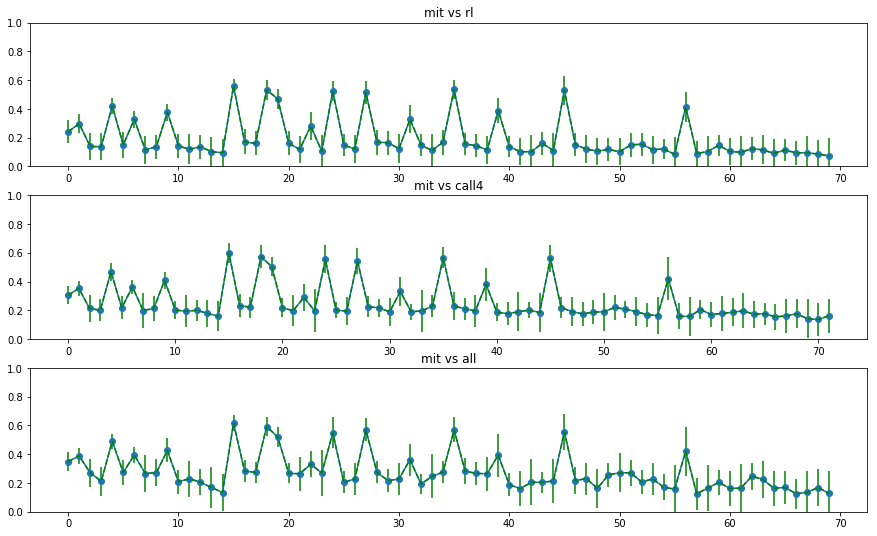

In [226]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
count = 1
for cell in correlations['mit']:
    ax = plt.subplot(3, 1, count)
    count += 1
    y = np.mean(correlations['mit'][cell][1:,:], axis=0)
    y_error = np.std(correlations['mit'][cell][1:,:], axis=0)
    ax.plot(x, y, marker="o", label="mit vs %s"%cell)
    ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
    ax.set_title("mit vs %s"%cell)
    ax.set_ylim([0, 1])

plt.show()

# Comparing cancer cells only:

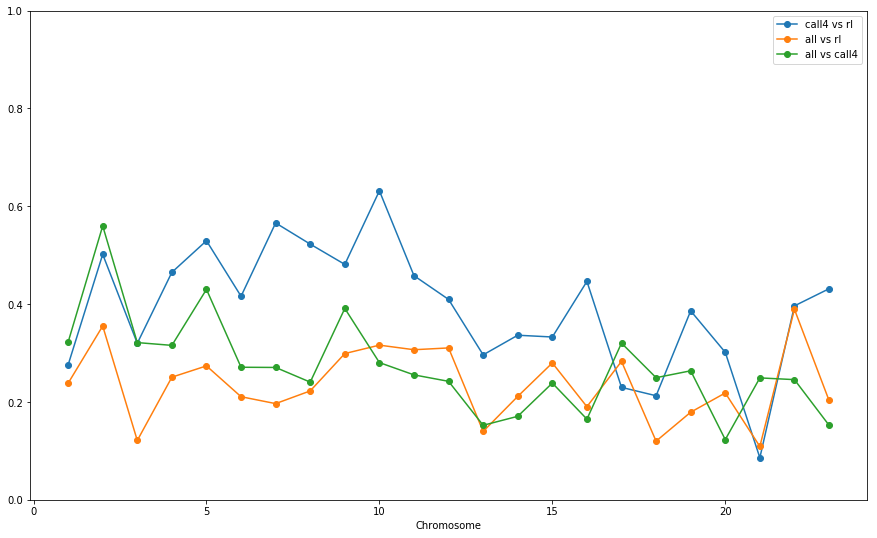

In [12]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(1, 24)
ax = plt.subplot(1, 1, 1)
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        y = np.nanmean(correlations[cell1][cell2][1:,:], axis=1)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.set(ylim=[0, 1], xlabel='Chromosome')
plt.legend()
plt.show()

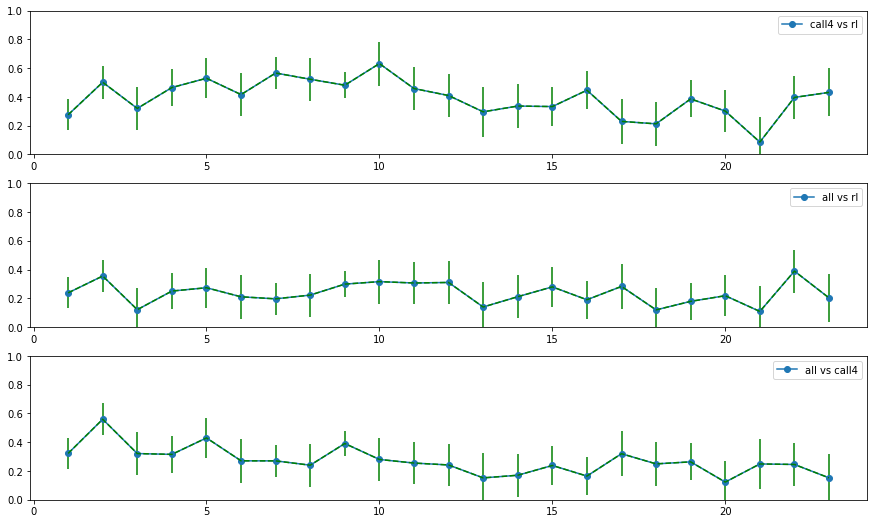

In [10]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(1, 24)
count = 1
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        ax = plt.subplot(3, 1, count)
        count += 1
        y = np.nanmean(correlations[cell1][cell2][1:,:], axis=1)
        y_error = np.nanstd(correlations['mit'][cell][1:,:], axis=1)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.legend()
        ax.set_ylim([0, 1])
plt.show()

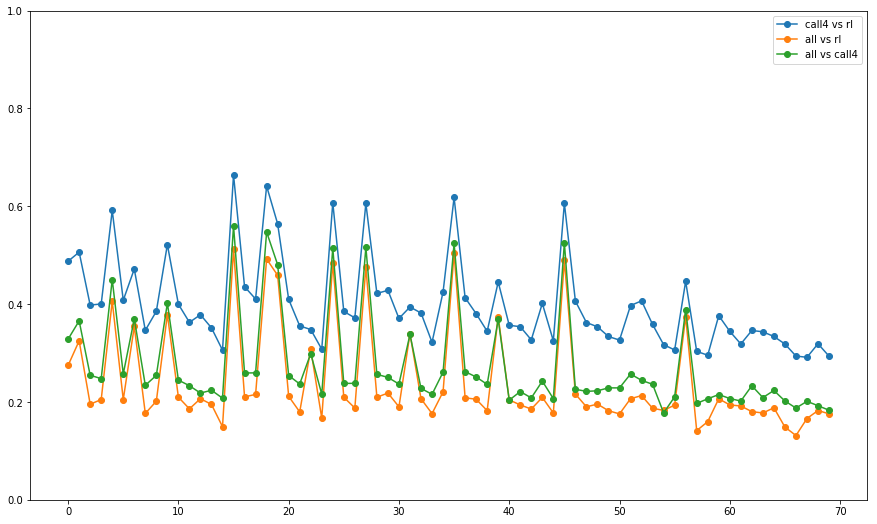

In [223]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
ax = plt.subplot(1, 1, 1)
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        y = np.mean(correlations[cell1][cell2][1:,:], axis=0)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.set_ylim([0, 1])
plt.legend()
plt.show()

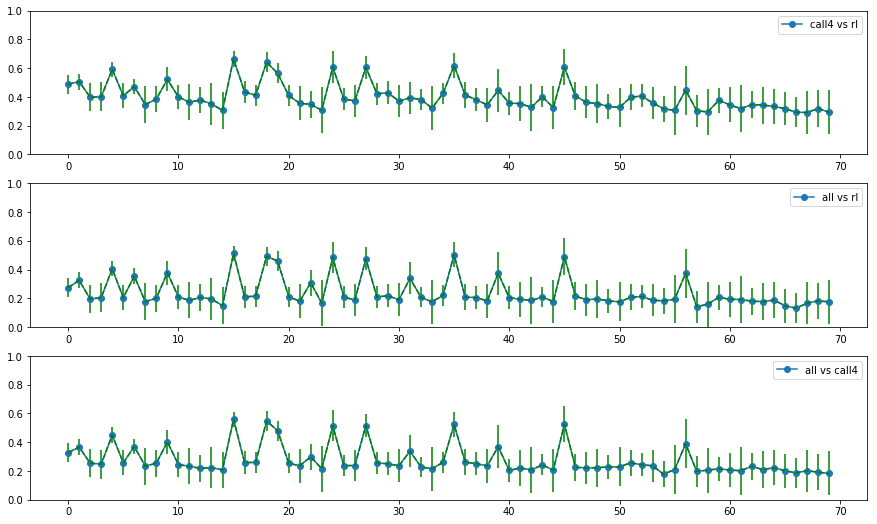

In [222]:
pylab.rcParams['figure.figsize'] = (15, 9)
x = range(0, 73)
count = 1
for cell1 in correlations:
    if cell1 == 'mit':
        continue
    for cell2 in correlations[cell1]:
        if cell2 == 'mit' or cell1 > cell2:
            continue
        ax = plt.subplot(3, 1, count)
        count += 1
        y = np.mean(correlations[cell1][cell2][1:,:], axis=0)
        y_error = np.std(correlations['mit'][cell][1:,:], axis=0)
        ax.plot(x, y, marker="o", label="%s vs %s"%(cell1, cell2))
        ax.errorbar(x, y, yerr=y_error, linestyle="dashed", marker="None", color="green")
        ax.set_ylim([0, 1])
        ax.legend()
plt.show()